<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


---

### Full Name: Niloufar Abbasi


---

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 106963400.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 74545042.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 33335541.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5039822.43it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

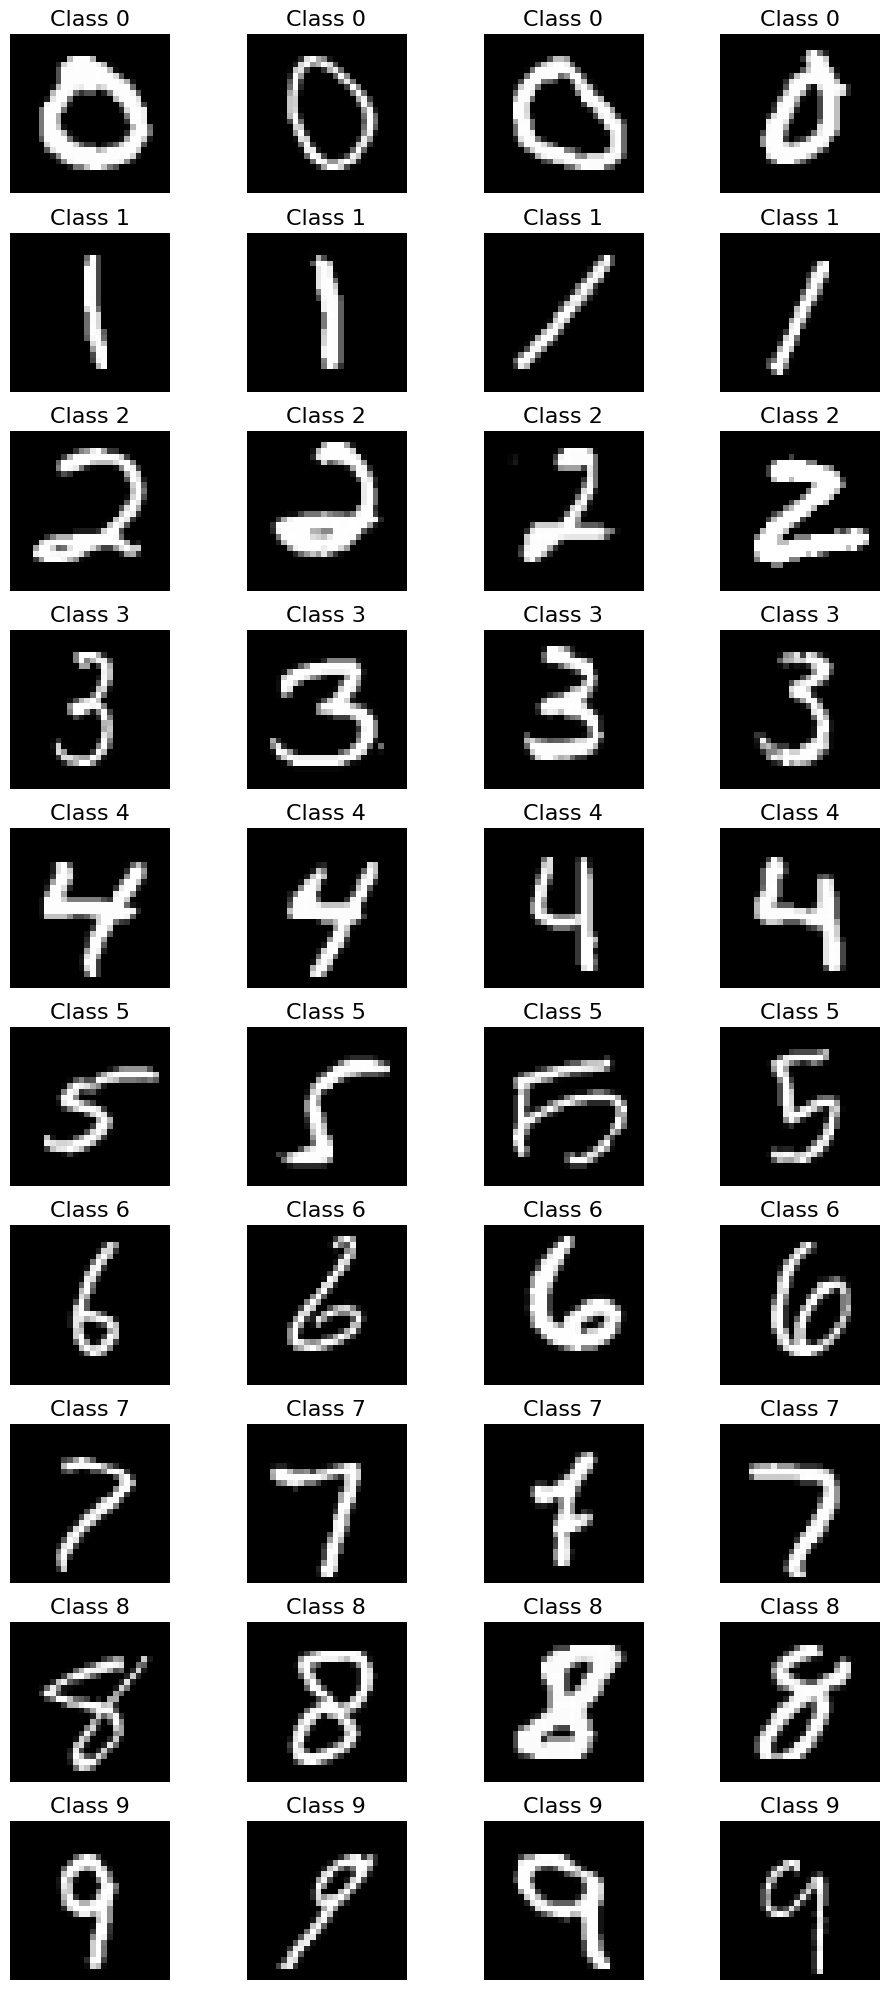

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        self.input_dim  = 28*28   #H*W
        self.hidden_dim = [784 , 512, 256, 128]
        self.latent_dim = 2  #H_d
        self.fc_mu      = None
        self.fc_logvar  = None
        #-----------------------------------------------------------------------
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.LeakyReLU(0.05)
        )
        #-----------------------------------------------------------------------
        self.fc_mu     = nn.Linear(self.hidden_dim[3], self.latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_dim[3], self.latent_dim)
        #-----------------------------------------------------------------------
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(self.latent_dim, hidden_dim[3]),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim[3], hidden_dim[2]),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim[2], hidden_dim[1]),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim[0], input_dim), #output_dim should be the same as input_dim
            nn.Sigmoid()  # To get output in the range [0, 1]
        )
    #---------------------------------------------------------------------------
    '''def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        epsilon = torch.randn_like(logvar)
        z = mu + torch.exp(0.5 * logvar) * epsilon
        return z
        #pass'''
    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    #---------------------------------------------------------------------------
    def forward(self, x):
        # TODO: Implement the forward pass
        x       = self.encoder(x)
        mu      = self.fc_mu(x)
        logvar  = self.fc_logvar(x)
        z       = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon , mu, logvar


my encoder and decoder each have three layers, which is within the range of 2 to 4 layers as specified.

In [6]:
# Define VAE loss function
def vae_loss(recon, data, mu, logvar):
    # Reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon.view(-1, 28*28), data.view(-1, 28*28), reduction='sum') #how well the VAE can reconstruct the input data

    # KL Divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #how much the learned latent distribution deviates from a standard normal distribution

    # Total loss
    total_loss = reconstruction_loss + kl_divergence

    return total_loss

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            # Forward process
            data = data.view(-1, 28*28)

            recon, mu, logvar = model(data)

            #Flatten the data and recon tensors
            data = data.view(data.size(0), -1)
            recon = recon.view(recon.size(0), -1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        #Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TSave the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


##################################################
VAE-MLP Epoch [1/10], Loss: 179.3461863769531
Sample Images:


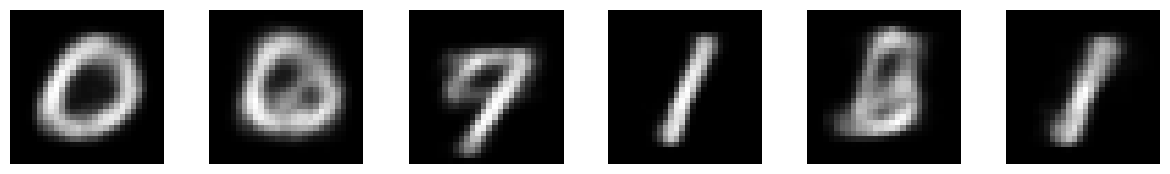


##################################################
VAE-MLP Epoch [2/10], Loss: 153.90993345540363
Sample Images:


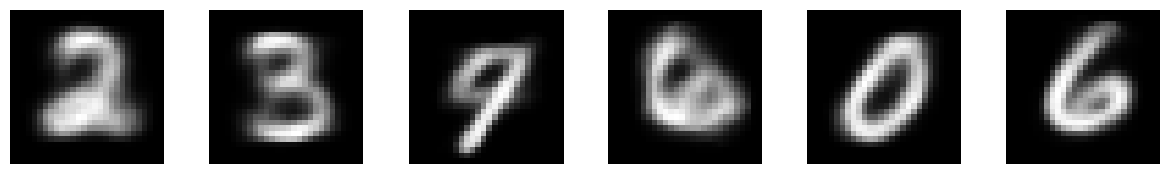


##################################################
VAE-MLP Epoch [3/10], Loss: 148.70947469889322
Sample Images:


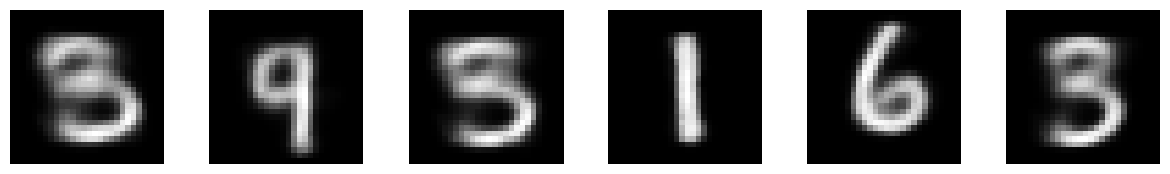


##################################################
VAE-MLP Epoch [4/10], Loss: 146.18314861653647
Sample Images:


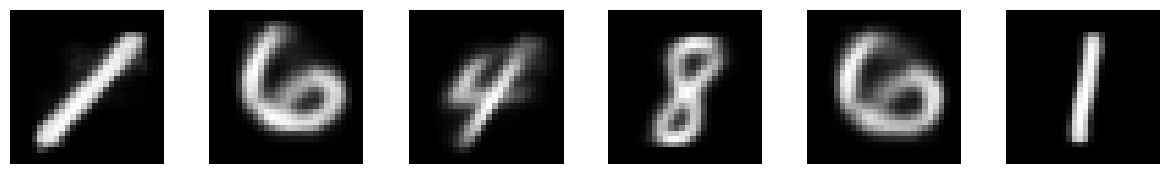


##################################################
VAE-MLP Epoch [5/10], Loss: 144.74741977539063
Sample Images:


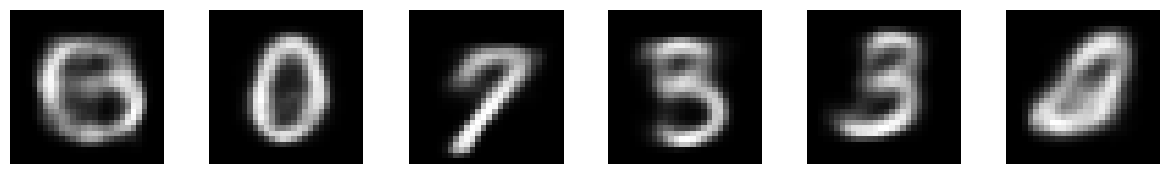


##################################################
VAE-MLP Epoch [6/10], Loss: 144.41090071614585
Sample Images:


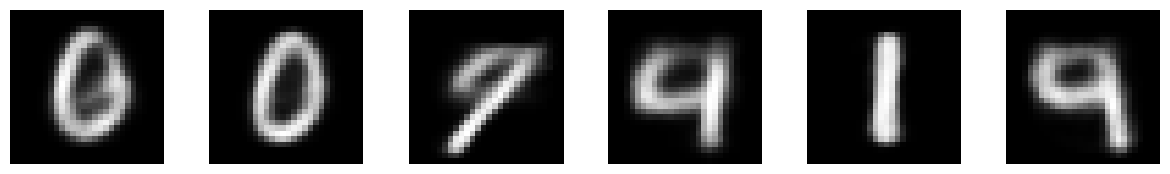


##################################################
VAE-MLP Epoch [7/10], Loss: 142.8842716308594
Sample Images:


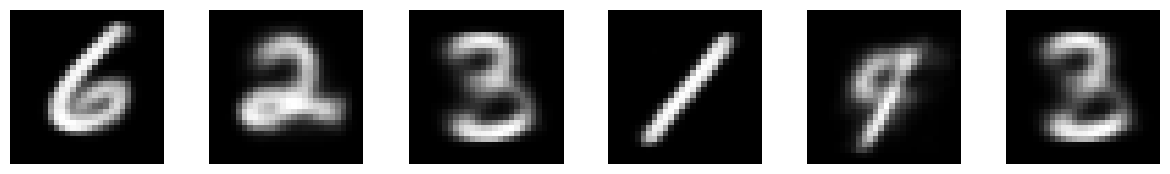


##################################################
VAE-MLP Epoch [8/10], Loss: 142.2830283610026
Sample Images:


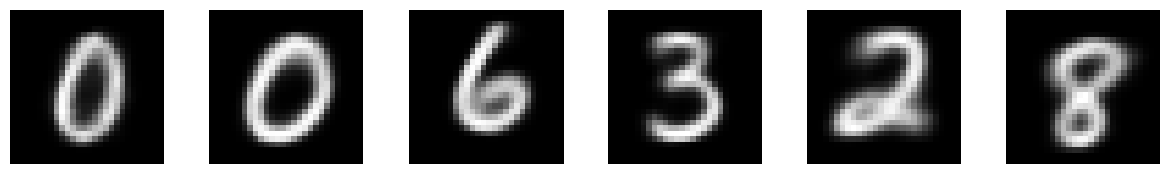


##################################################
VAE-MLP Epoch [9/10], Loss: 142.5653231201172
Sample Images:


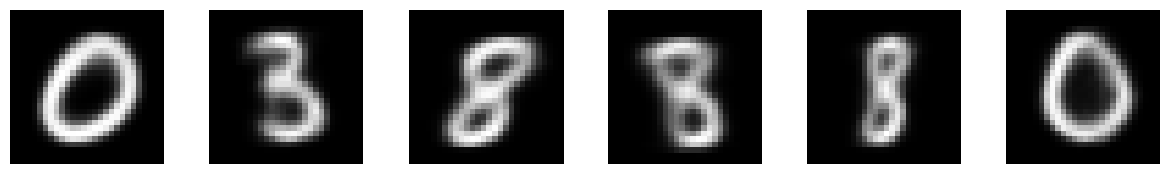


##################################################
VAE-MLP Epoch [10/10], Loss: 141.94290845540365
Sample Images:


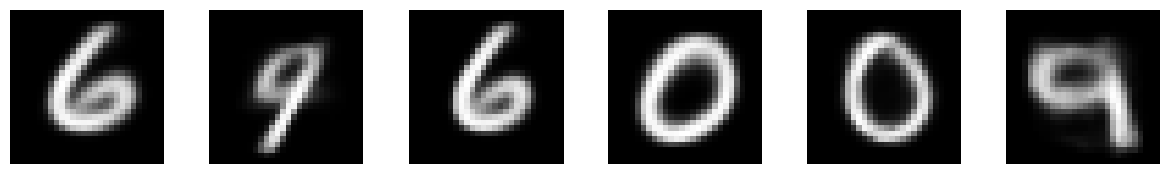

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=28*28, hidden_dim=[784,512,256,128], latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

---

we observed that the loss was decreasing over the course of the training process. With the number of epochs set to 10, we noticed a consistent downward trend in the loss. It is expected that if we continue training for more epochs, the loss will likely decrease further.

---

# 2) CVAE --> MLP

In [9]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        self.input_dim  = 28*28   #H*W
        self.hidden_dim = [784 , 512, 256, 128]
        self.latent_dim = 2  #H_d
        self.fc_mu      = None
        self.fc_logvar  = None
        #-----------------------------------------------------------------------
        self.encoder = nn.Sequential(
            nn.Linear(input_dim+num_classes, hidden_dim[0]),  # Adjust this line
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.LeakyReLU(0.05)
        )
        #-----------------------------------------------------------------------
        self.fc_mu     = nn.Linear(hidden_dim[3], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[3], latent_dim)
        self.fc_class  = nn.Linear(hidden_dim[3], num_classes)
        #-----------------------------------------------------------------------
        #Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(num_classes+latent_dim, hidden_dim[3]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[3], hidden_dim[2]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[2], hidden_dim[1]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.LeakyReLU(0.05),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Sigmoid()
            #nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )
    #---------------------------------------------------------------------------
    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    #---------------------------------------------------------------------------
    def forward(self, x, y):
        x             = x.view(x.size(0), -1)
        y             = y.view(y.size(0), -1)
        xy            = torch.cat((x, y), dim=1)          # Concatenate x and y before passing them to the encoder
        hidden        = self.encoder(xy)                  # Encoder
        mu            = self.fc_mu(hidden)                # Compute mean, log-variance, and class logits
        logvar        = self.fc_logvar(hidden)
        z             = self.reparameterize(mu, logvar)   # Reparameterization trick
        class_logits  = self.fc_class(hidden)
        zy            = torch.cat((z, y), dim=1)          # Concatenate z and class information before passing to the decoder
        reconstructed = self.decoder(zy)                  # Decoder
        return reconstructed, mu, logvar, class_logits

In [10]:
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(data.size(0), -1)

    # Reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels)

    # Total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss

In [11]:
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # One-hot encode the labels
            labels_one_hot = torch.eye(10)[labels]

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)

        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")


##################################################
CVAE-MLP Epoch [1/10], Loss: 163.29556220703125
Sample Images:


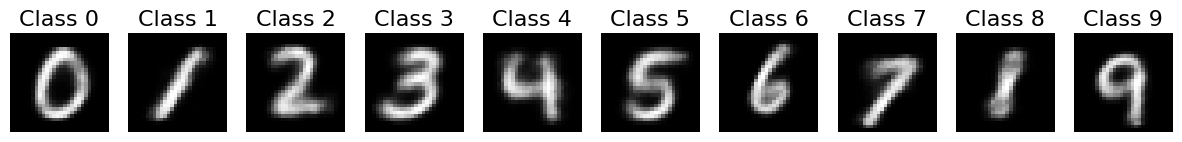


##################################################
CVAE-MLP Epoch [2/10], Loss: 136.9301722330729
Sample Images:


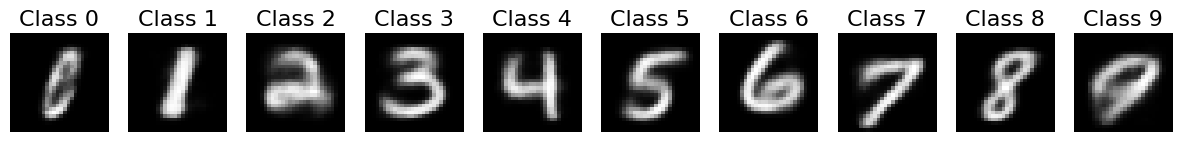


##################################################
CVAE-MLP Epoch [3/10], Loss: 133.45732915852864
Sample Images:


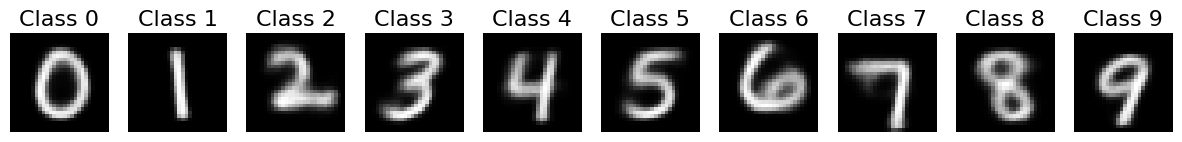


##################################################
CVAE-MLP Epoch [4/10], Loss: 132.0630384847005
Sample Images:


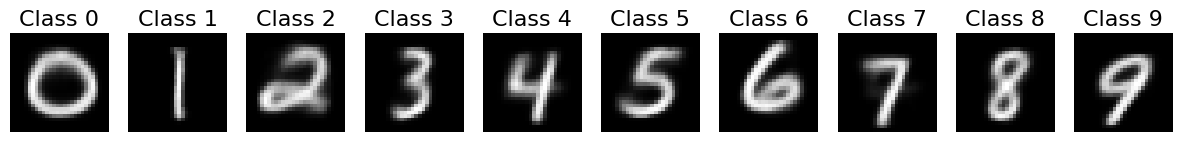


##################################################
CVAE-MLP Epoch [5/10], Loss: 131.1460869466146
Sample Images:


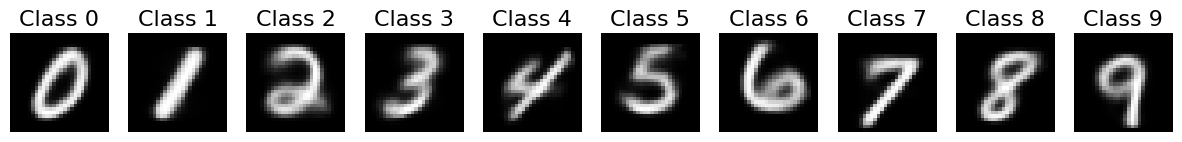


##################################################
CVAE-MLP Epoch [6/10], Loss: 130.4222569905599
Sample Images:


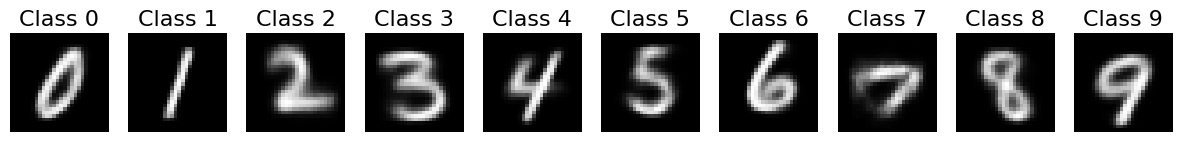


##################################################
CVAE-MLP Epoch [7/10], Loss: 129.9761344482422
Sample Images:


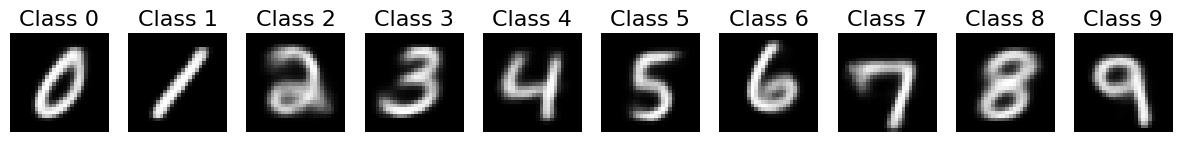


##################################################
CVAE-MLP Epoch [8/10], Loss: 129.40524200032553
Sample Images:


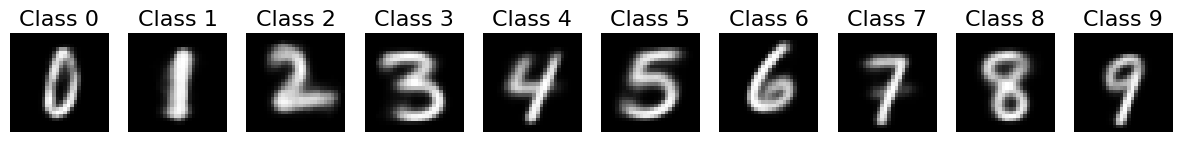


##################################################
CVAE-MLP Epoch [9/10], Loss: 129.2133861694336
Sample Images:


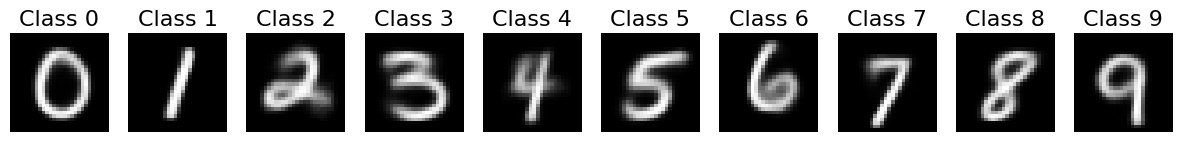


##################################################
CVAE-MLP Epoch [10/10], Loss: 128.64449749348958
Sample Images:


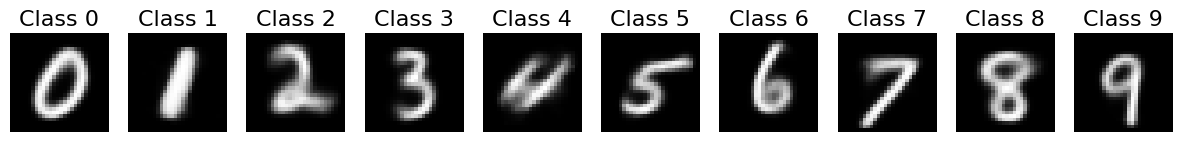

Best model saved as 'best_cvae_mlp_model.pth'


In [12]:
cvae_mlp = CVAE_MLP(input_dim=28*28, hidden_dim=[784,512,256,128], latent_dim=2, num_classes=10)  # Instantiate the CVAE_MLP model
train_cvae_mlp(cvae_mlp, train_loader)                                                            # Train the CVAE_MLP model

---

we observed that the loss was decreasing over the course of the training process. With the number of epochs set to 10, we noticed a consistent downward trend in the loss. It is expected that if we continue training for more epochs, the loss will likely decrease further.

---

---

In just 10 epochs, we observed that both the VAE and CVAE models, with a latent space dimension of 2, exhibited impressive performance. Despite our dataset being relatively easy, the models demonstrated remarkable capabilities that were not overshadowed by the simplicity of the data. Even in the early epochs, the models showcased their ability to reconstruct meaningful images of digits.

---

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


---

To visualize the latent space distribution for the VAE (MLP) and CVAE (MLP) models, we can follow these steps:

Generate a set of random samples in the latent space.
Decode the samples using the decoder of each model.
Plot the decoded samples in a scatter plot, with each point representing a sample in the latent space.

---

Latent space of VAE


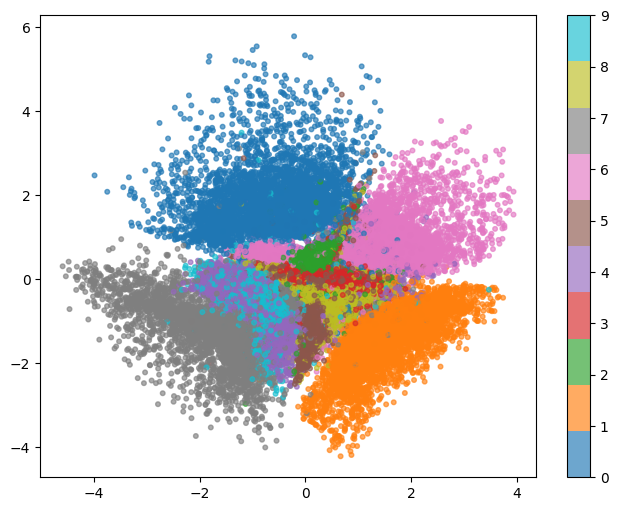

Latent space of CVAE


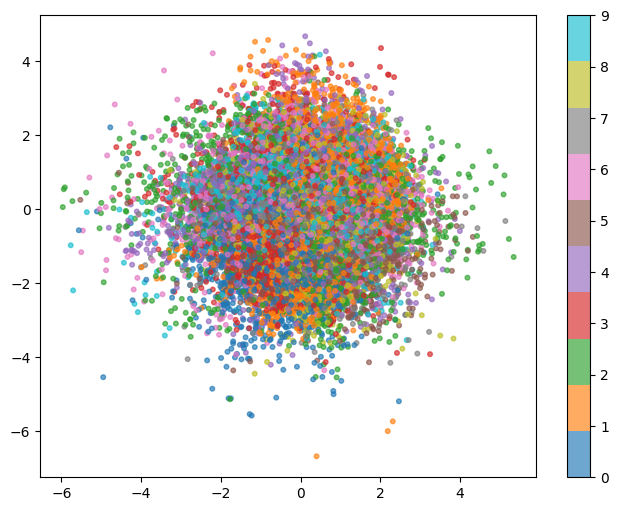

In [24]:
def visualize_latent_space(model, data_loader, num_samples=50000, is_cvae=False):
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model
    zs = []
    ys = []
    for i, (x, y) in enumerate(data_loader):
        if i * data_loader.batch_size > num_samples:
            break
        with torch.no_grad():
            x = x.view(x.size(0), -1).to(device)  # Ensure x is on the same device as the model
            y_one_hot = F.one_hot(y, num_classes=10).float().to(device)  # Ensure y is on the same device as the model
            if is_cvae:
                _, mu, _, _ = model(x, y_one_hot)
            else:
                _, mu, _ = model(x)
            zs.append(mu.to('cpu'))  # Move mu to CPU so that it can be used with matplotlib
            ys.append(y)
    zs = torch.cat(zs, dim=0)
    ys = torch.cat(ys, dim=0)
    plt.figure(figsize=(8, 6))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap='tab10' , s=11, alpha=0.65)
    plt.colorbar()
    plt.show()


# Visualize the latent space distribution of the VAE
print("Latent space of VAE")
visualize_latent_space(vae_mlp, train_loader, is_cvae=False)

# Visualize the latent space distribution of the CVAE
print("Latent space of CVAE")
visualize_latent_space(cvae_mlp, train_loader, is_cvae=True)


---

The explanation of what Ive done in the visualization code :

* The function **visualize_latent_space** takes a model  (VAE or CVAE), a data_loader , and some optional parameters.

* It sets the model to evaluation mode

* It retrieves the device of the model using next(model.parameters()).device to ensure consistency.

* It initializes empty lists to store the latent vectors and corresponding labels.

* It iterates over the data loader, converting the input data and labels to the appropriate device, and passes them through the model to obtain the latent vectors **mu**.

* It concatenates the zs and ys lists along the specified dimension.

* It plots the scatter plot of the latent space, with zs[:, 0] and zs[:, 1] as the x and y coordinates, ys as the color mapping, and cmap='tab10' to specify the color map.

---

▶ explanation of the differences in the behavior of the plots for VAE and CVAE when visualizing the latent space distribution:

⚪ VAE Plot:

In the VAE plot, Although our model was a simple model, the different classes are somewhat separated, and in this plot the latent space distribution represents the learned representations of the input data without considering any additional class information.so the scatter plot will display the distribution of latent vectors generated by the VAE. The colors in the plot will represent the original labels or classes of the input data.The VAE plot aims to capture the underlying structure of the data in an unsupervised manner..

⚪ CVAE Plot:

In the CVAE plot, the latent space distribution takes into account the class information or labels of the input data. The scatter plot will display the distribution of latent vectors generated by the CVAE, considering both the input data and their corresponding labels. The colors in the plot will represent the predicted or inferred classes based on the latent vectors.
The CVAE plot aims to capture **both the underlying structure of the data** and **the class-related information**. (The condition is important here.) The clusters or patterns observed in the CVAE plot may reflect both the intrinsic properties of the data and the separation or grouping of samples according to their classes.

◻ In summary,

**the key difference in behavior between the VAE plot and the CVAE plot lies in the consideration of class information. The VAE plot focuses on unsupervised learning and provides insights into the overall distribution of the latent space. On the other hand, the CVAE plot incorporates class information, allowing for a more class-aware representation of the latent space, potentially revealing patterns or separations specific to different classes.**

---

### visualize the latent space distribution using the test data to evaluate the model's generalization capabilities :

In [19]:
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Latent space of VAE


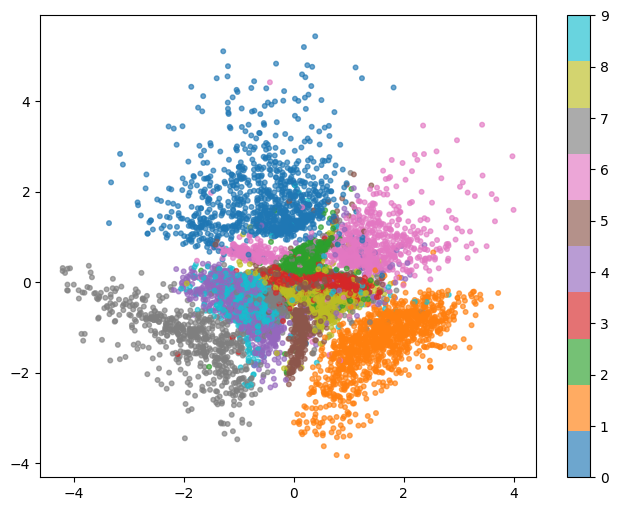

Latent space of CVAE


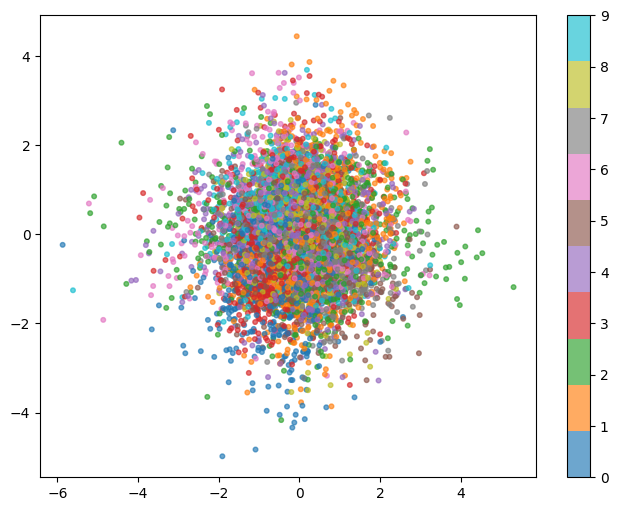

In [25]:
# Load test data using a separate test data loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Visualize the latent space distribution of the VAE using the test data
print("Latent space of VAE")
visualize_latent_space(vae_mlp, test_loader,num_samples=10000, is_cvae=False)

# Visualize the latent space distribution of the CVAE using the test data
print("Latent space of CVAE")
visualize_latent_space(cvae_mlp, test_loader,num_samples=10000, is_cvae=True)

---

Some additional points to consider:

* we know that the MNIST dataset consists of 50,000 training images and 10,000 test images, not 60,000 and 10,000 as previously stated. (this is the reason of the choice for num_samples)

* some digits, such as 9 and 4, have similar forms that can pose challenges for simple models to differentiate accurately. The shared structural elements, like curves and straight lines, contribute to their visual similarity.

---